# Sentiment analysis on movie reviews

This notebook seeks to predict positive or negative comments regarding the Amazon Alexa product

## Dataset

First of all, let's load the reviews to start processing them.
```
movie_reviews/
  neg/
  pos/
``` 

In [27]:
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.datasets import load_files
moviedir = r'./dataset/movie_reviews' 
movie_reviews = load_files(moviedir, shuffle=True)

Now in the `movies` variable we will have the reviews (`movies.data`) and their sentiment (`movies.target`) saved.
Let's see how many reviews we have in total:

In [2]:
print("Tenemos {} reviews, con clases {},".format(len(movie_reviews.data), movie_reviews.target_names))

Tenemos 2000 reviews, con clases ['neg', 'pos'],


Analyzing the structure of the documents, let's see what a sample of `movies.data` looks like:

In [3]:
movie_reviews.data[0][:500]

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so cal"

And now, with the `target` property we can see the category associated with this review

In [4]:
movie_reviews.target[0]

0

In this case it is a 0, or `neg`.

## Separating into training and testing sets

Before starting with the training of the models trying different algorithms to find the best models, we are going to separate the set of reviews into training and testing.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    movie_reviews.data, movie_reviews.target, test_size = 0.20, stratify=movie_reviews.target, random_state = 12)

## Preprocessing

To work with text we have to perform a series of steps before we can train a model. That is, find a way to convert the text to a numerical representation that can be interpreted by classification algorithms.
- Tokenize the text
- Convert to vectors of terms/documents
- Apply tfidf


In [6]:
#Importing the libraries
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

#Stopwords
stopwords = nltk.corpus.stopwords.words('english')


#tf-idf
tf_idf=TfidfVectorizer(stop_words=stopwords,lowercase=True, ngram_range=(1,2), max_features=15000)
X_train = tf_idf.fit_transform(X_train).toarray()
X_test = tf_idf.transform(X_test).toarray()


### Dimension of the array of terms
Once the documents are vectorized, let's see what shape the resulting matrix has

In [7]:
X_train.shape

(1600, 15000)

In [8]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Training the models
Once we have a matrix with the vectors corresponding to the documents after applying td-idf we can start the model training process. For that, we are going to compare different algorithms like SVM, Random Forest, AdaBoost, Voting.
For the training of the models we will use GridSearch going through a list of parameters as appropriate to each algorithm. In addition we will use 5-fold CV and the scoring will be given by the area under the roc curve.

### Support Vector Machines (SVM)

Our parameter space to traverse using GridSearch will be as follows:

* C = [0.001, 0.01, 0.1, 1, 10]
* loss = ['hinge', 'squared_hinge'] 


In [9]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV

svc=LinearSVC(random_state=42)
param_grid={"C" : [0.001, 0.01, 0.1, 1, 10] ,"loss" : ['hinge', 'squared_hinge'] }
grid_search= GridSearchCV(svc, param_grid, cv=5, scoring="roc_auc")

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=42, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'loss': ['hinge', 'squared_hinge']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

Let's see the averaged results for each combination of parameters:

In [10]:
import pandas as pd
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score',ascending=False)[['params','rank_test_score','mean_test_score']]

,params,rank_test_score,mean_test_score
7,"{'C': 1, 'loss': 'squared_hinge'}",1,0.924641
9,"{'C': 10, 'loss': 'squared_hinge'}",2,0.923820
8,"{'C': 10, 'loss': 'hinge'}",3,0.923016
6,"{'C': 1, 'loss': 'hinge'}",4,0.922328
5,"{'C': 0.1, 'loss': 'squared_hinge'}",5,0.907734
3,"{'C': 0.01, 'loss': 'squared_hinge'}",6,0.889492
1,"{'C': 0.001, 'loss': 'squared_hinge'}",7,0.885977
0,"{'C': 0.001, 'loss': 'hinge'}",8,0.885414
2,"{'C': 0.01, 'loss': 'hinge'}",8,0.885414
4,"{'C': 0.1, 'loss': 'hinge'}",8,0.885414


In [11]:
grid_search.best_params_

{'C': 1, 'loss': 'squared_hinge'}

In [12]:
optimised_svm = grid_search.best_estimator_
optimised_svm

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

## Confusion Matrix 

In [13]:
import numpy as np
import itertools
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



Normalized confusion matrix
[[0.805 0.195]
 [0.125 0.875]]


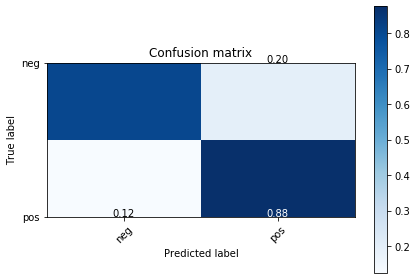

In [14]:
y_pred=optimised_svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm,movie_reviews.target_names)

Calculate the area under the ROC curve (AUC) on the test set for the model.

In [15]:
print("Score_auc_roc:",roc_auc_score(y_test, y_pred))
acc_svm=accuracy_score(y_test, y_pred)
print("Score_acc:",acc_svm)

print(classification_report(y_test, y_pred))

Score_auc_roc: 0.84
Score_acc: 0.84
              precision    recall  f1-score   support

           0       0.87      0.81      0.83       200
           1       0.82      0.88      0.85       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



### Random Forests
The next model that we are going to train is using the Random Forest technique. 


* n_estimators = [100, 500, 1000]
* max_depth: [3, 7, None]
* min_samples_split: [2, 3, 10]
* bootstrap: [True, False]
* criterion: ["gini", "entropy"]



In [16]:
from sklearn.ensemble import RandomForestClassifier

rdf=RandomForestClassifier(random_state=42)
param_grid={"n_estimators" : [100, 500, 1000] ,"max_depth" : [3, 7, None], "min_samples_split" : [2, 3, 10], 
            "bootstrap" :[True, False] , "criterion" : ["gini", "entropy"] } 
grid_search= GridSearchCV(rdf, param_grid, cv=5, scoring="roc_auc")

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 1000}
Normalized confusion matrix
[[0.89  0.11 ]
 [0.165 0.835]]


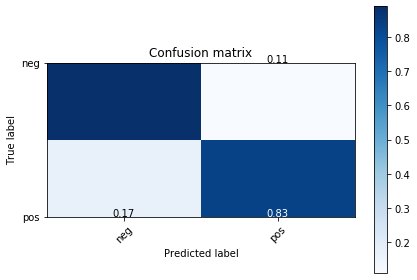

Score_auc_roc: 0.8625
Score_acc: 0.8625
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       200
           1       0.88      0.83      0.86       200

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



,params,rank_test_score,mean_test_score
101,"{'bootstrap': False, 'criterion': 'entropy', '...",1,0.907687
104,"{'bootstrap': False, 'criterion': 'entropy', '...",2,0.907504
100,"{'bootstrap': False, 'criterion': 'entropy', '...",3,0.906379
107,"{'bootstrap': False, 'criterion': 'entropy', '...",4,0.906305
103,"{'bootstrap': False, 'criterion': 'entropy', '...",5,0.905180
...,...,...,...
30,"{'bootstrap': True, 'criterion': 'entropy', 'm...",104,0.851055
27,"{'bootstrap': True, 'criterion': 'entropy', 'm...",105,0.850859
3,"{'bootstrap': True, 'criterion': 'gini', 'max_...",106,0.848148
6,"{'bootstrap': True, 'criterion': 'gini', 'max_...",107,0.848125


In [17]:
print(grid_search.best_params_)
optimised_rdf = grid_search.best_estimator_

y_pred=optimised_rdf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,movie_reviews.target_names)

print("Score_auc_roc:",roc_auc_score(y_test, y_pred))
acc_rdf=accuracy_score(y_test, y_pred)
print("Score_acc:",acc_rdf)

print(classification_report(y_test, y_pred))
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score',ascending=False)[['params','rank_test_score','mean_test_score']]

### Multilayer Perceptron

Values: `{'hidden_layer_sizes': [(10,),(5,5), (2,2)]}`

In [18]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=42)
param_grid={'hidden_layer_sizes': [(10,),(5,5), (2,2)]}
grid_search= GridSearchCV(mlp, param_grid, cv=5, scoring="roc_auc")

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=42, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'hidden_layer_sizes': [(10,), (5, 5), (2, 2

{'hidden_layer_sizes': (10,)}
Normalized confusion matrix
[[0.845 0.155]
 [0.11  0.89 ]]


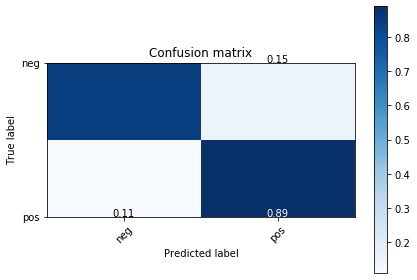

Score_auc_roc: 0.8675
Score_acc: 0.8675
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       200
           1       0.85      0.89      0.87       200

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



,params,rank_test_score,mean_test_score
0,"{'hidden_layer_sizes': (10,)}",1,0.916969
1,"{'hidden_layer_sizes': (5, 5)}",2,0.916180
2,"{'hidden_layer_sizes': (2, 2)}",3,0.910336


In [19]:
print(grid_search.best_params_)
optimised_mlp = grid_search.best_estimator_

y_pred=optimised_mlp.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,movie_reviews.target_names)

print("Score_auc_roc:",roc_auc_score(y_test, y_pred))
acc_mlp=accuracy_score(y_test, y_pred)
print("Score_acc:",acc_mlp)

print(classification_report(y_test, y_pred))
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score',ascending=False)[['params','rank_test_score','mean_test_score']]

### AdaBoost

Values: `{'n_estimators': [50, 100, 500]}`


In [20]:
from sklearn.ensemble import AdaBoostClassifier

ada=AdaBoostClassifier()
param_grid={'n_estimators':[50, 100, 500]}
grid_search= GridSearchCV(ada, param_grid, cv=5, scoring="roc_auc")

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': [50, 100, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

{'n_estimators': 500}
Normalized confusion matrix
[[0.795 0.205]
 [0.17  0.83 ]]


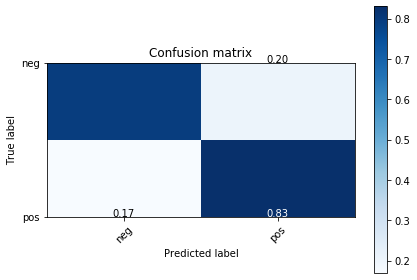

Score_auc_roc: 0.8125000000000001
Score_acc: 0.8125
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       200
           1       0.80      0.83      0.82       200

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



,params,rank_test_score,mean_test_score
2,{'n_estimators': 500},1,0.863375
1,{'n_estimators': 100},2,0.843797
0,{'n_estimators': 50},3,0.831605


In [21]:
print(grid_search.best_params_)
optimised_ada = grid_search.best_estimator_

y_pred=optimised_ada.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,movie_reviews.target_names)

print("Score_auc_roc:",roc_auc_score(y_test, y_pred))
acc_ada=accuracy_score(y_test, y_pred)
print("Score_acc:",acc_ada)

print(classification_report(y_test, y_pred))
pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score',ascending=False)[['params','rank_test_score','mean_test_score']]

__We will build an ensemble between the four models using voting and measure the accuracy of each of the models.__


In [22]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[("svm",optimised_svm), ("mlp", optimised_mlp), ("rdf",optimised_rdf), 
                                          ("ab", optimised_ada)],voting='hard')
voting_clf.fit(X_train,y_train)

y_pred = voting_clf.predict(X_test)

print("Accuracy_voting_clf:",accuracy_score(y_test, y_pred))
print("Accuracy_svm:",acc_svm)
print("Accuracy_rdf:",acc_rdf)
print("Accuracy_mlp:",acc_mlp)
print("Accuracy_ada:",acc_ada)

Accuracy_voting_clf: 0.8825
Accuracy_svm: 0.84
Accuracy_rdf: 0.8625
Accuracy_mlp: 0.8675
Accuracy_ada: 0.8125


__I select the model with the best score and retrain it__

In [29]:
eclf=optimised_mlp

movie_reviews_data= tf_idf.fit_transform(movie_reviews.data).toarray()
eclf.fit(movie_reviews_data,movie_reviews.target)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [30]:
# Saving the model
from sklearn.externals import joblib
joblib.dump(eclf, 'sentiment.pkl') 

['sentiment.pkl']

## Rocky 4 review rating.

From [Rocky 4 movie reviews](https://www.rottentomatoes.com/m/rocky_iv/reviews/?type=user) let's see how our best model ranks them

In [31]:
reviews_new = ["Stallone creates credible villains worthy of his heroic character.",
               "Another brilliant Rocky film, probably my favourite one out of the lot",
               "Yeah, this movie sucks.",
               "My favourite rocky film! So good so much heart. Slightly better than 2",
               "What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!",
               "The new film's narrative is stripped down to essentials, which gives it an emblematic quality.",
               "Absurdly ridiculous, this just isn't a good movie at all", 
               "Very basic and predictable but still an okay movie. No special music to save this one.", 
              "Rocky 4 is an extremely ambitious movie that is definitely worth watching.",
              'Highly beautiful',
               "If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would otherwise be nothing more than an interminable series of mildly rousing montages. There are some unintentionally funny bits though, and Dolph's Ivan showcases the best and worst of all Rocky's opponents.",
              "While all aspects of realism is thrown out the window, ROCKY IV is an adrenaline rush of action and excitment, with an incredible soundtrack and arguably the best movie fight in history between Balboa and Drago",
              "Just like the songs, exercise routines and repetitive clips, it seems redundant to add another installment in this already falling franchise when you clearly lack material. Rocky IV is petty, childish and seems overlong despite of its 91 minutes of run time for it merely has an idea of a TV drama episode which is stretched to a point of exhaustion. Its painful to watch Sylvester Stallone go through this enormous amount of training and hardly make a point out there. He fails on all the levels here; writer, director and actor, to deliver any loose end of the thread for the audience to hang on to. Rocky IV is predictable, loosely written and choreographed and executed unsupervised."]

reviews_new_tfidf = tf_idf.transform(reviews_new)

In [32]:
pred = eclf.predict(reviews_new_tfidf)

In [33]:
for review, category in zip(reviews_new, pred):
    print('%r => %s \n' % (review, movie_reviews.target_names[category]))

'Stallone creates credible villains worthy of his heroic character.' => pos 

'Another brilliant Rocky film, probably my favourite one out of the lot' => pos 

'Yeah, this movie sucks.' => neg 

'My favourite rocky film! So good so much heart. Slightly better than 2' => pos 

'What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!' => neg 

"The new film's narrative is stripped down to essentials, which gives it an emblematic quality." => pos 

"Absurdly ridiculous, this just isn't a good movie at all" => neg 

'Very basic and predictable but still an okay movie. No special music to save this one.' => neg 

'Rocky 4 is an extremely ambitious movie that is definitely worth watching.' => pos 

'Highly beautiful' => pos 

"If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would oth